In [2]:
import tensorflow as tf
tf.__version__

'2.5.0-dev20210327'

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from PIL import Image, ImageOps

from os import listdir
from os.path import isfile, join

# training data
image_size = 224
labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/fgvc7/images"
NP_dir = "data/NP_img/images"

In [4]:
# import image data and combine labels
X = []
y = []

for f in listdir(image_dir):
    if isfile(join(image_dir, f)):
        # add filename
        #train_list.append(f)
        # add image to the list
        img = load_img(f'{image_dir}/{f}', target_size=(image_size,image_size,3))
        img_array = img_to_array(img, dtype='uint8')
        
        img_g = load_img(f'{image_dir}/{f}', target_size=(image_size,image_size,1), color_mode='grayscale')
        img_array_g = img_to_array(Image.merge('RGB', (img_g, img_g, img_g)), dtype='uint8')
        
        X.append(img_array)
        y.append([1,0])
        
        X.append(img_array_g)
        y.append([1,0])
            
for f in listdir(NP_dir):
    if isfile(join(NP_dir, f)):
        # add filename
        #train_list.append(f)
        # add image to the list
        img = load_img(f'{NP_dir}/{f}', target_size=(image_size,image_size,3))
        img_array = img_to_array(img, dtype='uint8')
        
        img_g = load_img(f'{NP_dir}/{f}', target_size=(image_size,image_size,1), color_mode='grayscale')
        img_array_g = img_to_array(Image.merge('RGB', (img_g, img_g, img_g)), dtype='uint8')
        
        

        X.append(img_array)
        y.append([0,1])
        
        X.append(img_array_g)
        y.append([0,1])
            
data_y = np.array(y, dtype=np.uint16)   
data_x = np.array(X, dtype=np.uint16)

In [5]:
#for i in data_x:
 #   imgplot = plt.imshow(i)
  #  plt.show()
   # print(i.shape)
    
len(data_x)

70850

## Augmentation

In [6]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-90,90)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        ,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        ,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        ,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)

In [7]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


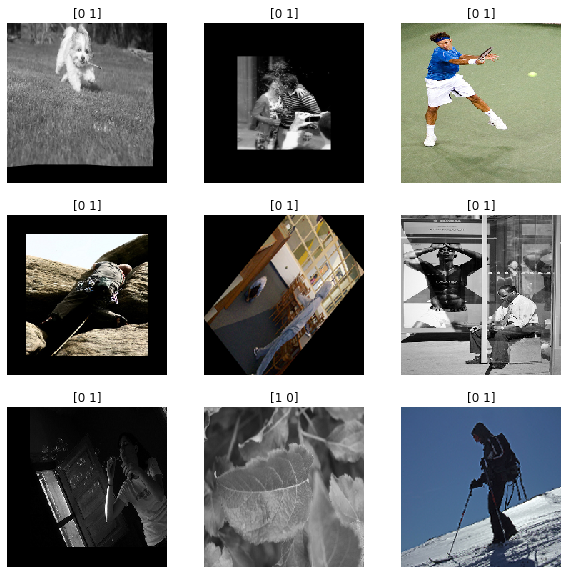

In [8]:
images = generator(data_x,data_y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(str(image[1][i]))
    plt.axis("off")

## Transfer Learning

In [9]:
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.30, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

#test_x, test_id  = load_data("Test") 

In [10]:
base_model = applications.EfficientNetB0(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

In [11]:
# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [12]:
# Warm up head
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 256
#num_warmup_steps = 5

# freeze pretrained weights
model.layers[1].trainable = False

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])


history = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=10,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model.optimizer.lr)


# Train entire network
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

# freeze pretrained weights
model.layers[1].trainable = True

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=5,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/10
193/193 [==============================] - 1299s 7s/step - loss: 0.7684 - sparse_categorical_crossentropy: 0.7684 - val_loss: 0.1839 - val_sparse_categorical_crossentropy: 0.1839
Epoch 2/10
193/193 [==============================] - 1265s 7s/step - loss: 0.2136 - sparse_categorical_crossentropy: 0.2136 - val_loss: 0.1431 - val_sparse_categorical_crossentropy: 0.1431
Epoch 3/10
193/193 [==============================] - 1261s 7s/step - loss: 0.1512 - sparse_categorical_crossentropy: 0.1512 - val_loss: 0.1092 - val_sparse_categorical_crossentropy: 0.1092
Epoch 4/10
193/193 [==============================] - 1258s 6s/step - loss: 0.1272 - sparse_categorical_crossentropy: 0.1272 - val_loss: 0.0951 - val_sparse_categorical_crossentropy: 0.0951
Epoch 5/10
193/193 [==============================] - 1238s 6s/step - loss: 0.1181 - sparse_categorical_crossentropy: 0.1181 - val_loss: 0.1086 - val_sparse_categorical_crossentropy: 0.1086
Epoch 6/10
193/193 [==============================

In [58]:
model.save('models/error_mod3')

/Users/vnicholascirella/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: models/error_mod3/assets


In [230]:
maxIter = 3
iter = 0

# Train entire network
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)


model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

while iter < maxIter:
    test_y = model.predict(test_x)
    test_pred = tf.nn.softmax(test_y).numpy()
    pred_label = np.argmax(test_pred, axis=1)
    
    merged_data_x = np.vstack((x_train, test_x))
    merged_data_y = np.vstack((y_train.reshape(-1,1), pred_label.reshape(-1,1)))

    history2 = model.fit(generator(merged_data_x, merged_data_y, batch_size),  
                        shuffle=True,  
                        validation_data = (x_val, y_val),
                        callbacks = [reduce_lr,early_stop],                        
                        epochs=200,
                        steps_per_epoch=len(merged_data_x)/batch_size ,
                        verbose=True
                       )
    
    iter += 1

NameError: name 'test_x' is not defined

In [239]:
model = keras.models.load_model('models/error_mod3')

False leaf count: 14
False non-leaf count: 23


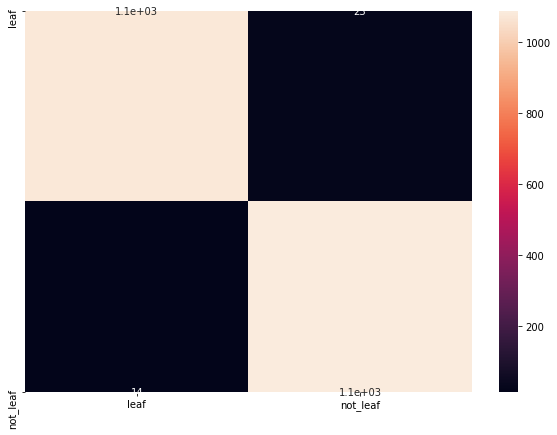

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['leaf', 'not_leaf']

y_pred_base = model.predict(test_x_val)
y_pred_base_g = model.predict(test_x_val_g)

y_val_pred = np.argmax(y_pred_base, axis=1)
#y_val_pred_g = np.argmax(y_pred_base_g, axis=1)


#y_val_pred = np.argmax(np.add(y_pred_base_g, y_pred_base), axis=1)
        
for i in range(len(y_val_pred)):
    if y_pred_base[i][1] < 2:
        y_val_pred[i] = 0
    if y_pred_base_g[i][1] < 2:
        y_val_pred[i] = 0
    if abs(y_pred_base_g[i][1] - y_pred_base[i][1]) > 2 or abs(y_pred_base[i][1] - y_pred_base_g[i][1]) > 2:
        y_val_pred[i] = 0

z = 0
q = 0
for i in range(len(y_val_pred)):
    if y_val_pred[i] != test_y_val[i]:
        if(test_y_val[i] == 1):
            z += 1
        else:
            q += 1
        
print("False leaf count: " + str(z))
print("False non-leaf count: " + str(q))
        
mat = confusion_matrix(test_y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [27]:
# import image data and combine labels
np_test = "data/NP_img/test_np"
leaf_test = "data/NP_img/test_p"

X = []
y = []

X_g = []
y_g = []


for f in listdir(leaf_test)[:1100]:
    if isfile(join(leaf_test, f)):
        # add filename
        #train_list.append(f)
        # add image to the list
        img = load_img(f'{leaf_test}/{f}', target_size=(image_size,image_size,3))
        img_array = img_to_array(img, dtype='uint8')

        img_g = load_img(f'{leaf_test}/{f}', target_size=(image_size,image_size,1), color_mode='grayscale')
        img_array_g = img_to_array(Image.merge('RGB', (img_g, img_g, img_g)), dtype='uint8')
        
        X.append(img_array)
        y.append(0)

        X_g.append(img_array_g)
        y_g.append(0)

for f in listdir(np_test)[:1100]:
    if isfile(join(np_test, f)):
        # add filename
        #train_list.append(f)
        # add image to the list
        img = load_img(f'{np_test}/{f}', target_size=(image_size,image_size,3))
        img_array = img_to_array(img, dtype='uint8')
        
        img_g = load_img(f'{np_test}/{f}', target_size=(image_size,image_size,1), color_mode='grayscale')
        img_array_g = img_to_array(Image.merge('RGB', (img_g, img_g, img_g)), dtype='uint8')

        X.append(img_array)
        y.append(1)

        X_g.append(img_array_g)
        y_g.append(1)

        
test_y_val = np.array(y, dtype=np.uint16)   
test_x_val = np.array(X, dtype=np.uint16)

test_y_val_g = np.array(y_g, dtype=np.uint16)   
test_x_val_g = np.array(X_g, dtype=np.uint16)